$\Large \text{Testing 1/4 degree simulation}$ 

The test run was forced with analytical wind stress, surface heat flux and freshwater forcing. Sponge was used in 2 deg region to restore temperature and salinity near the northern boundary. The run used EOS from Wright et al. (1997). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
%matplotlib inline

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44343 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 406.01 GB


$\large \text{Stats time series}$

In [6]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/Z_star//TS_Wright/"
ds_stat = xr.open_dataset(ppdir+"ocean.stats.nc")
print(ds_stat)

ds_n = xr.open_dataset(ppdir+"prog.nc",decode_times=False)
dsgrid = xr.open_dataset(ppdir+"grid.nc", decode_times=False)
dsgrid = dsgrid.drop('Time')

ds_n = xr.merge([ds_n, dsgrid])
print(ds_n)

<xarray.Dataset>
Dimensions:        (Interface: 76, Layer: 75, Time: 721)
Coordinates:
  * Layer          (Layer) float64 0.5 2.393 6.02 ... 3.848e+03 3.949e+03
  * Interface      (Interface) float64 0.0 1.0 3.787 ... 3.898e+03 4e+03
  * Time           (Time) timedelta64[ns] 0 days 10 days ... 7190 days 7200 days
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
    Salt           (Time) float64 ...
    Salt_chg       (Time) float64 ...
    Salt_anom      (Time) float64 ...
    Heat           (Time) float64 ...
    Heat_chg       (Time) float64 ...
    Heat_anom      (Time)

Text(0, 0.5, 'Domain Mean Salinity (psu)')

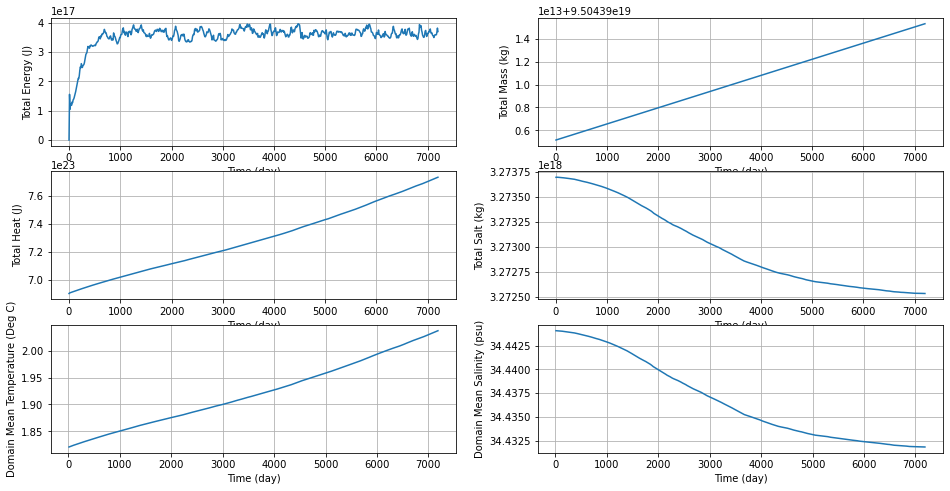

In [5]:
plt.figure(figsize=(16,8))

plt.subplot(3,2,1)
plt.plot(ds_stat['Time']/(24*3600*1e9), ds_stat['En'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Energy (J)')

plt.subplot(3,2,2)
plt.plot(ds_stat['Time']/(1e9*3600*24), ds_stat['Mass'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Mass (kg)')

plt.subplot(3,2,3)
plt.plot(ds_stat['Time']/(1e9*3600*24), ds_stat['Heat'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Heat (J)')

plt.subplot(3,2,4)
plt.plot(ds_stat['Time']/(1e9*3600*24), ds_stat['Salt'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Salt (kg)')

plt.subplot(3,2,5)
plt.plot(ds_n['Time'], ds_n['thetaoga'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Domain Mean Temperature (Deg C)')

plt.subplot(3,2,6)
plt.plot(ds_n['Time'], ds_n['soga'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Domain Mean Salinity (psu)')

In [31]:
#dA = (ds_n['dxt'] * ds_n['dyt']).sum()
#2*np.diff(ds_stat['Mass'].values)/(3600.*24.*10.)
(ds_stat['Mass'].values[-1]  - ds_stat['Mass'].values[0])

10157316308992.0

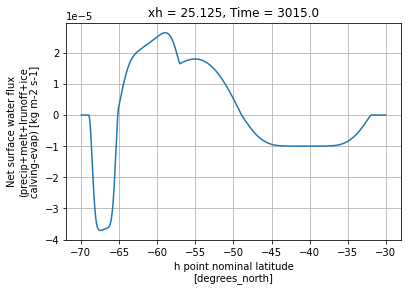

In [11]:
ds_n['PRCmE'].isel(Time=100,xh=100).plot()
plt.grid()

In [42]:
dA = ds_n['dxt'] * ds_n['dyt']
#FW_flux = (ds_n['PRCmE'].isel(Time=100,xh=100)* dA).sum() /dA.sum()
FW_flux1 = (ds_n['PRCmE']* ds_n['area_t']).isel(Time=10).sum()
FW_flux2 = (ds_n['PRCmE']* dA).isel(Time=10).sum()
print((FW_flux1 * 7200. * 24. * 3600.).values, (FW_flux2 * 7200. * 24. * 3600.).values)

10159966080000.0 21690996480000.0


In [48]:
print((ds_n['PRCmE'].isel(Time=10) * ds_n['area_t']).isel(xh=0).drop('Time').mean(), 
      (ds_n['PRCmE'].isel(Time=10) * ds_n['dxt'] * ds_n['dyt'] ).isel(xh=0).drop('Time').mean())

<xarray.DataArray ()>
array(0.18761489, dtype=float32)
Coordinates:
    xh       float64 0.125 <xarray.DataArray ()>
array(0.40067786, dtype=float32)
Coordinates:
    xh       float64 0.125


In [46]:
ds_n['PRCmE'].isel(Time=10) * ds_n['dxt'] * ds_n['dyt']

<xarray.DataArray (yh: 272, xh: 320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * yh       (yh) float64 -69.94 -69.85 -69.77 -69.68 ... -30.46 -30.24 -30.02
    Time     float64 315.0

In [47]:
ds_n['PRCmE'].isel(Time=10) * ds_n['area_t']

<xarray.DataArray (yh: 272, xh: 320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * yh       (yh) float64 -69.94 -69.85 -69.77 -69.68 ... -30.46 -30.24 -30.02
    Time     float64 315.0

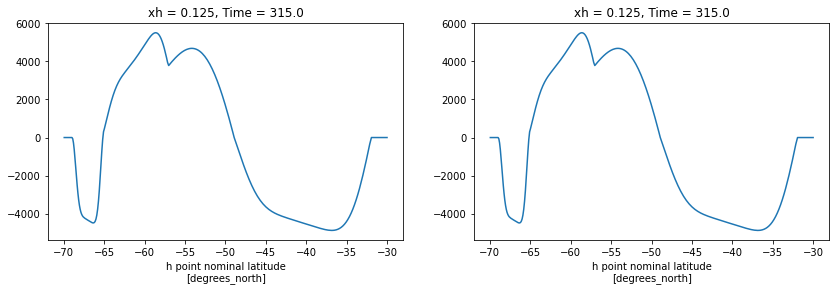

In [43]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(ds_n['PRCmE'].isel(Time=10) * ds_n['area_t']).isel(xh=0).plot()

plt.subplot(1,2,2)
(ds_n['PRCmE'].isel(Time=10) * ds_n['dxt'] * ds_n['dyt'] ).isel(xh=0).plot()

In [6]:
ds_n.close()
ds_stat.close()

$\large \text{Spatial fields}$

In [49]:
ds_z = xr.open_dataset(ppdir+"prog_z.nc",decode_times=False)
print(ds_z)

#ds_rho = xr.open_mfdataset(ppdir+"prog_rho2*.nc",decode_times=False)
#print(ds_rho)

<xarray.Dataset>
Dimensions:     (Time: 20, nv: 2, xh: 320, xq: 320, yh: 272, yq: 272, z_i: 36, z_l: 35)
Coordinates:
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * yh          (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * z_l         (z_l) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
  * z_i         (z_i) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
  * Time        (Time) float64 180.0 540.0 900.0 ... 6.3e+03 6.66e+03 7.02e+03
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 79.25 79.5 79.75 80.0
  * yq          (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
Data variables:
    temp        (Time, z_l, yh, xh) float32 ...
    salt        (Time, z_l, yh, xh) float32 ...
    u           (Time, z_l, yh, xq) float32 ...
    v           (Time, z_l, yq, xh) float32 ...
    umo         (Time, z_l, yh, xq) float32 ...
    vmo         (Time, z_l, yq, xh) float

In [50]:
dsgrid = xr.open_dataset(ppdir+"grid.nc", decode_times=False)
dsgrid = dsgrid.drop('Time')

ds_z = xr.merge([ds_z, dsgrid])
#ds_rho = xr.merge([ds_rho, dsgrid])

In [51]:
grid = Grid(ds_z, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': 'zl', 'outer': 'zi'} }, periodic=['X']);

/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='f

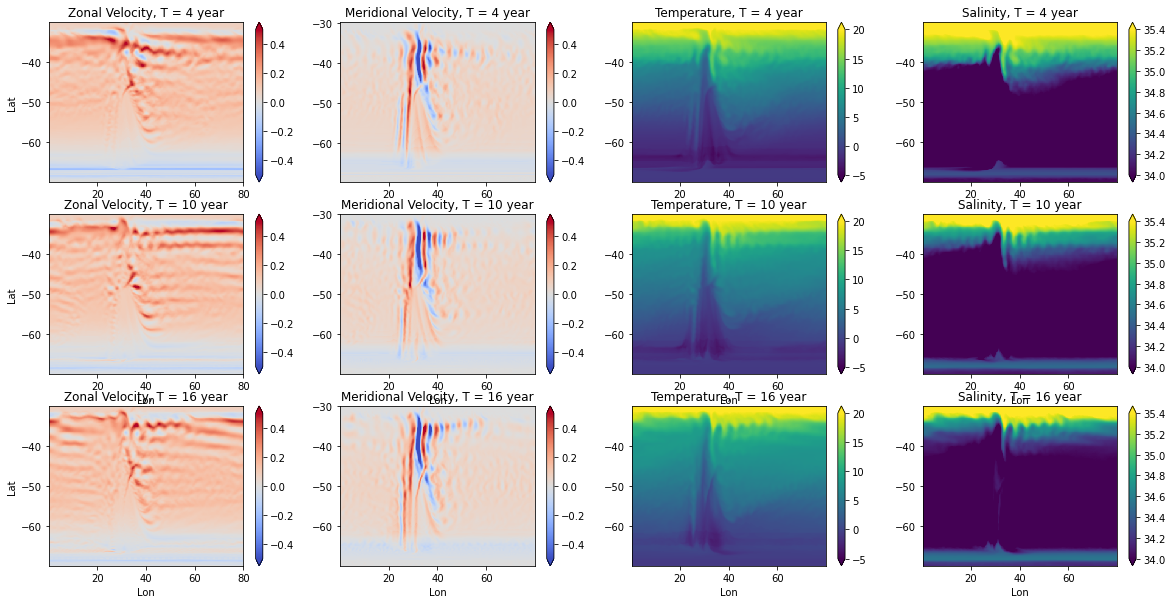

In [54]:
plt.figure(figsize=(20,10))

ct = 0
for i in range(3,20,6):
    plt.subplot(3,4,4*ct + 1)
    tmp = ds_z['u'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xq'], ds_z['yh'], tmp, vmin = -0.5, vmax = 0.5, cmap='coolwarm')
    plt.colorbar(extend='both')
    plt.ylabel('Lat')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Zonal Velocity, T = ' + str(i+1) + ' year')
    
    plt.subplot(3,4,4*ct + 2)
    tmp = ds_z['v'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xh'], ds_z['yq'], tmp, vmin = -0.5, vmax = 0.5, cmap='coolwarm')
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Meridional Velocity, T = ' + str(i + 1) + ' year')
    
    plt.subplot(3,4,4*ct + 3)
    tmp = ds_z['temp'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xh'], ds_z['yh'], tmp, vmin = -5, vmax = 20.)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Temperature, T = ' + str(i+1) + ' year')
    
    plt.subplot(3,4,4*ct + 4)
    tmp = ds_z['salt'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xh'], ds_z['yh'], tmp, vmin = 34., vmax = 35.4)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Salinity, T = ' + str(i+1) + ' year')
    
    ct = ct + 1

/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the s

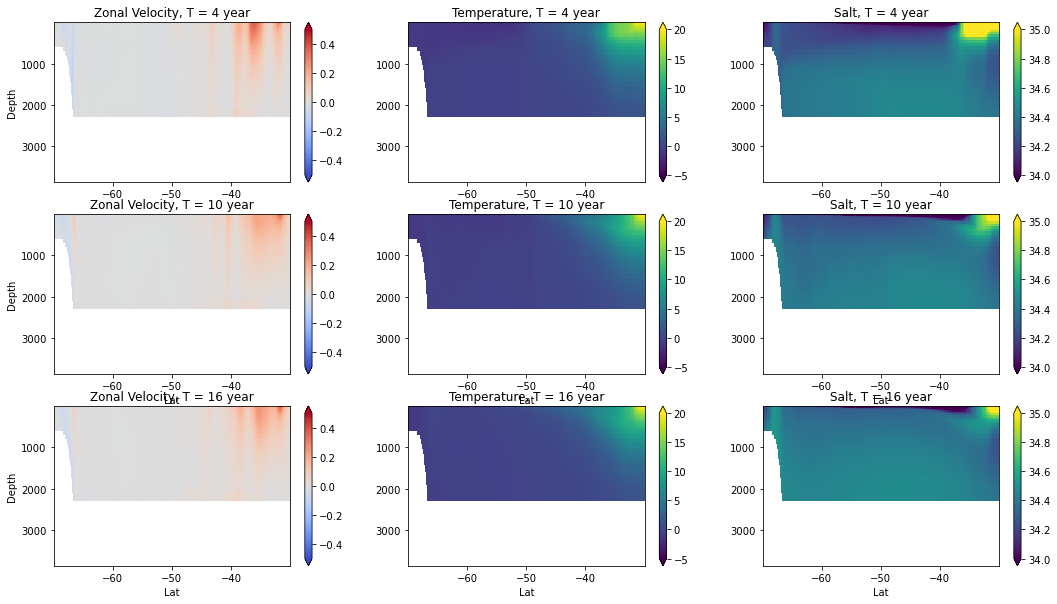

In [55]:
plt.figure(figsize=(18,10))

ct = 0
for i in range(3,20,6):
    plt.subplot(3,3,3*ct + 1)
    tmp = ds_z['u'].isel(Time = i, xq=120)
    plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = -0.5, vmax = 0.5, cmap='coolwarm')
    plt.colorbar(extend='both')
    plt.ylabel('Depth')
    if(ct>0):
        plt.xlabel('Lat')
    plt.title('Zonal Velocity, T = ' + str(i+1) + ' year')
    plt.gca().invert_yaxis()
    
    plt.subplot(3,3,3*ct + 2)
    tmp = ds_z['temp'].isel(Time = i, xh=120)
    plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = -5, vmax = 20.)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lat')
    plt.title('Temperature, T = ' + str(i+1) + ' year')
    plt.gca().invert_yaxis()
    
    plt.subplot(3,3,3*ct + 3)
    tmp = ds_z['salt'].isel(Time = i, xh=120)
    plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = 34.0, vmax = 35.0)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lat')
    plt.title('Salt, T = ' + str(i+1) + ' year')
    plt.gca().invert_yaxis()
    
    ct = ct + 1

Text(0.5, 1.0, '67 S')

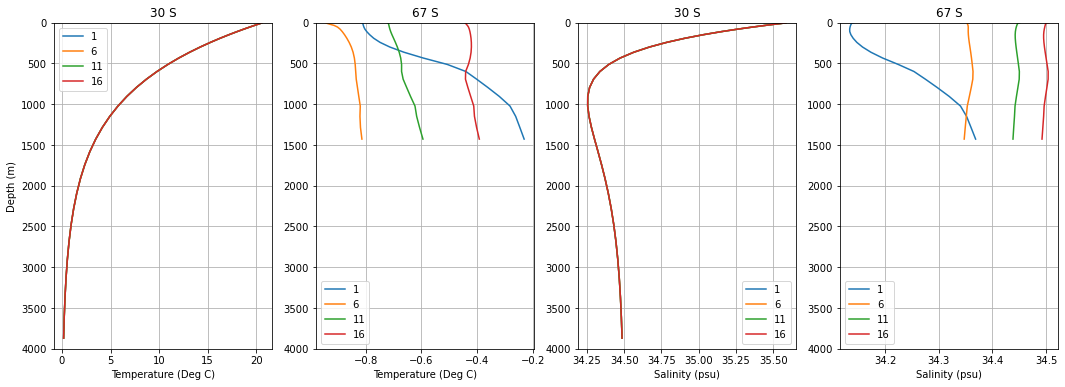

In [56]:
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
for i in range(0,20,5):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('30 S')

plt.subplot(1,4,2)
for i in range(0,20,5):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.legend()
plt.title('67 S')

plt.subplot(1,4,3)
for i in range(0,20,5):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.title('30 S')
plt.legend()

plt.subplot(1,4,4)
for i in range(0,20,5):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.legend()
plt.title('67 S')

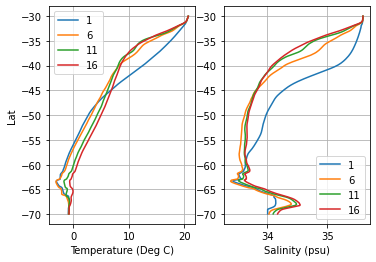

In [57]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
for i in range(0,20,5):
    tmp = ds_z['temp'].isel(Time=i).isel(z_l=0).mean('xh')
    plt.plot(tmp, ds_z['yh'], label = str(i+1))
plt.grid()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Lat')
plt.legend()

plt.subplot(1,4,2)
for i in range(0,20,5):
    tmp = ds_z['salt'].isel(Time=i).isel(z_l=0).mean('xh')
    plt.plot(tmp, ds_z['yh'], label = str(i+1))
plt.grid()
plt.xlabel('Salinity (psu)')
plt.legend()

In [59]:
#ds_rho.close()
ds_z.close()
client.close()
cluster.close()

$\Large \text{Sponge Check}$

In [3]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/Z_star//TS_Wright/"
ds_z = xr.open_dataset(ppdir+"sponge_Matt/prog_z.nc",chunks={"Time": 1},decode_times=False)
#ds = xr.open_dataset(ppdir+"sponge_check/prog.nc",chunks={"Time": 1},decode_times=False)

In [4]:
print(ds_z)
#print(ds)

<xarray.Dataset>
Dimensions:     (Time: 5, nv: 2, xh: 320, xq: 320, yh: 272, yq: 272, z_i: 36, z_l: 35)
Coordinates:
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * yh          (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * z_l         (z_l) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
  * z_i         (z_i) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
  * Time        (Time) float64 180.0 540.0 900.0 1.26e+03 1.62e+03
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 79.25 79.5 79.75 80.0
  * yq          (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
Data variables:
    temp        (Time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 272, 320), meta=np.ndarray>
    salt        (Time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 272, 320), meta=np.ndarray>
    u           (Time, z_l, yh, xq) float32 dask.array<chunksize=(1, 35, 272, 320), meta=np.

Text(0.5, 1.0, '67 S')

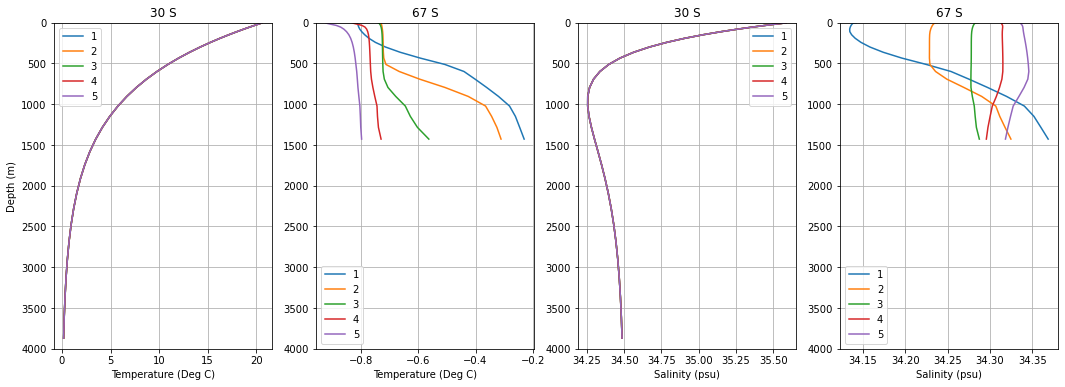

In [5]:
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
for i in range(0,5,1):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('30 S')

plt.subplot(1,4,2)
for i in range(0,5,1):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.legend()
plt.title('67 S')

plt.subplot(1,4,3)
for i in range(0,5,1):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.title('30 S')
plt.legend()

plt.subplot(1,4,4)
for i in range(0,5,1):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.legend()
plt.title('67 S')

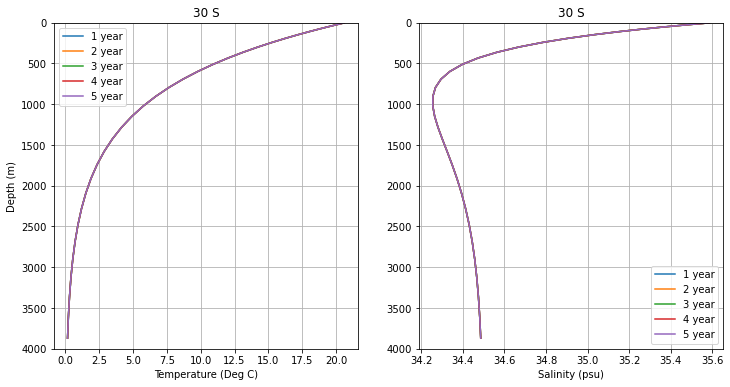

In [6]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
for i in range(0,5,1):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1) + ' year')
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('30 S')

plt.subplot(1,2,2)
for i in range(0,5,1):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1)+ ' year')
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.title('30 S')
plt.legend()

In [8]:
ds_z.close()
client.close()
cluster.close()